Numerical instabilities basically occur whenever the probability mass of a conditional distribution is largely concentrated on a very tiny intervall, for example in the lower of upper corner. This means, that points outside of the interval basically have no likelihood of occurrence, so that the conditional `cdf` will have horizontal vicinities. Inverting these horizontal vicinities would lead to a violation of the rule of functions that each $x$ value must be mapped to a unique $y$ value. In these cases the inverse function simply picks one of all possible underlying $x$ values, and all others can never be achieved through the inverse function. For simulation purposes this should not make a difference, since all of these points should never appear anyways.

Let's look at a couple of examples that threw some errors during unit testing.

In [47]:
using Copulas
using Winston

In [48]:
uLow = 0.001
uHigh = 0.999
testGrid = [uLow, 0.01:0.01:0.99, uHigh];

#### BB7

The following `BB7` copula exhibits a horizontal $v$-function in a local area for given $u_{1}=0.1$.

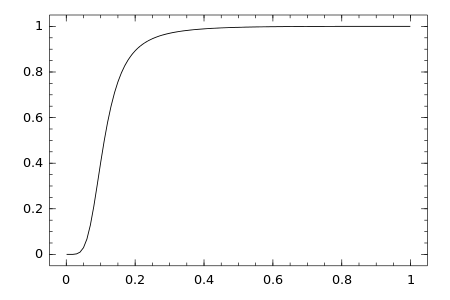

In [49]:
cop = BB7PC_Cpp([4.5,4.4])
vals = vfun(cop, testGrid, 0.1) # sudden jump from 0 to 1

plot(testGrid, vals)

This way, different $u_{2}$ values very close to 1 get mapped to the same value:

In [60]:
vfun(cop, [0.8, 0.9, 0.94, 0.99, 0.999], 0.1)

5-element Array{Float64,1}:
 0.999942
 0.999997
 1.0     
 1.0     
 1.0     

As we can see, the problem occurs since values in upper quantiles have a likelihood of almost 0:

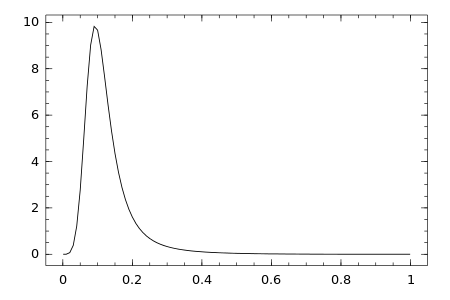

In [62]:
plot(testGrid, pdf(cop, 0.1, testGrid))

This of course causes problems with inversion, as the inverse $v$-function in principle would have multiple function values for a single $u_{2}$ value. In this case, the function gets assigned a single value for input 1.0:

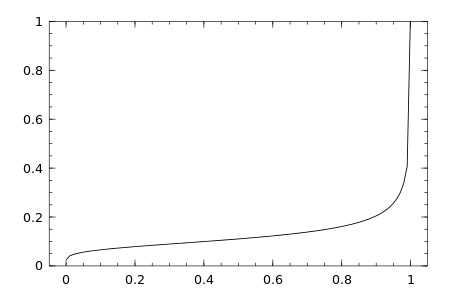

In [30]:
vals = vinv(cop, [testGrid[1:end-1], 1.0], 0.1)
plot(testGrid, vals)
ylim([0, 1])

Remark: if two $x$-values are too close to each other, Winston does show only one of them. Hence, simply attaching 1.0 to `testGrid` did not show the value for 1.0, so that I needed to replace the last grid point.

In [61]:
vinv(cop, 1., 0.1)

1-element Array{Float64,1}:
 1.0

Hence, although at least all values above 0.99 get mapped to 1 in the $v$-function, inverting this operation will always lead to a value of 1. Hence, $v^{-1}(v(x))\neq x$ for these values, but will always return value 1:

In [21]:
vals = vinv(cop, vfun(cop, [0.99, 0.999, 0.9999], 0.1), 0.1)

3-element Array{Float64,1}:
 1.0
 1.0
 1.0

Hence, a value $x$ with basically no probability of occurrence gets mapped to another value that should never occur.

Through this numerical instability, some values will never occur during simulation. In this case, values above 0.99  are impossible to simulate.

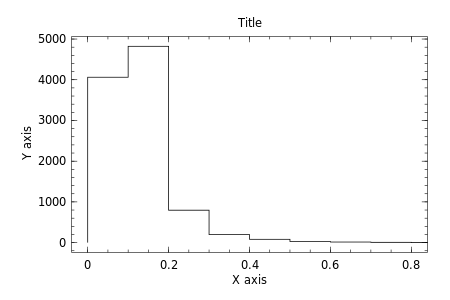

In [33]:
nSim = 10000
w2 = rand(nSim)
u2 = vinv(cop, w2, 0.1)

p = FramedPlot(
         title="Title",
         xlabel="X axis",
         ylabel="Y axis")

 add(p, Histogram(hist(u2)...))

In general, however, it should not matter much, as these values would have a too small likelihood anyways.

#### BB1

We can get the same problem for the BB1 copula if we plug in values of highly improbable regions.

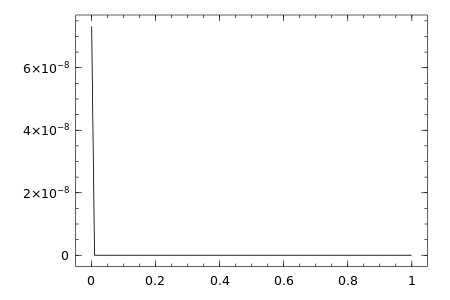

In [70]:
cop = BB1PC_Cpp([5.4,1.2])
u1 = 2.0e-5
u2 = 0.00098

plot(testGrid, pdf(cop, u1, testGrid))

The conditional distribution gives rise to a highly degenerated cdf:

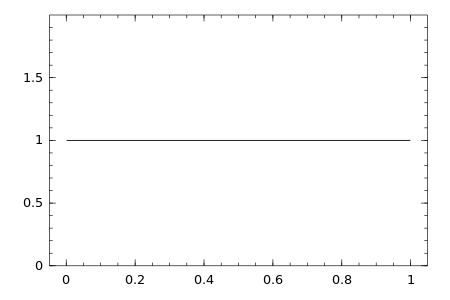

In [71]:
plot(testGrid, vfun(cop, testGrid, u1))

This way, $v^{-1}(v(x))$ will again map highly unlikely $x$ values to somewhere else. In this case, for $u_{1}=2.0\times 10^{-5}$ a value of $u_{2}=0.00098$ is already too unlikely and will be mapped all the way to a value of 1:

In [66]:
val = pdf(cop, u1, u2)

1-element Array{Float64,1}:
 8.5154e-8

In [68]:
q = vfun(cop, u2, u1)

1-element Array{Float64,1}:
 1.0

In [69]:
vinv(cop, q, u1)

1-element Array{Float64,1}:
 1.0

Only incredibly small numbers get a $v$-function value unequal to 1:

In [73]:
vfun(cop, 0.000001, u1)

1-element Array{Float64,1}:
 1.85479e-10

Looking a $v^{-1}$ we can see that almost all values will get mapped very close to 0, while only a very tine interval next to 1 will get mapped to different values:

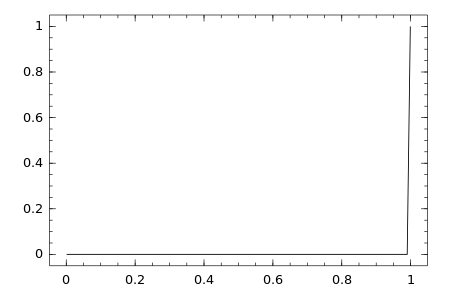

In [46]:
plot(testGrid, vinv(cop, [testGrid[1:end-1], 1.0], u1))

Although we can not see this in the picture, the function exhibits discontinuity, as there are values close to 1 that can never occur.

Still, simulation does not lead to unreliable results. In principle, some values in upper quantiles now have a probability of occurrence of 0. However, we should not observe them anyways.

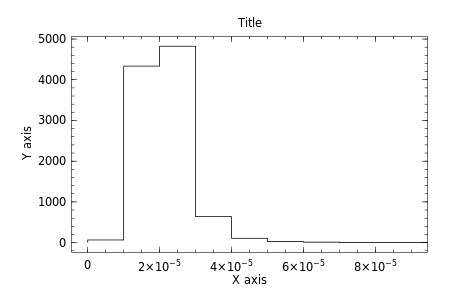

In [43]:
nSim = 10000
w2 = rand(nSim)
u2 = vinv(cop, w2, u1)

p = FramedPlot(
         title="Title",
         xlabel="X axis",
         ylabel="Y axis")

 add(p, Histogram(hist(u2)...))

#### BB6

For the `BB6` copula, the unit tests brought up a much worse numerical instability. Here, the $h$-function does never reach a value of 1:

In [90]:
cop = BB6PC_Cpp([5.4,0.2])
hfun(cop, 1., 0.999)

1-element Array{Float64,1}:
 0.63101

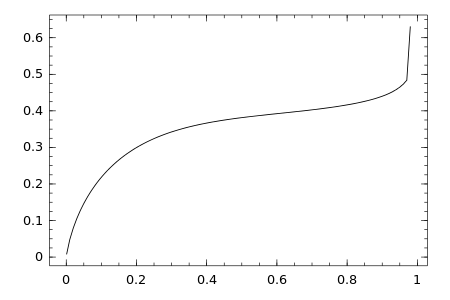

In [91]:
plot(testGrid, hfun(cop, [testGrid[1:end-3], 0.99999999], 0.999))

In this case, plugging values larger than this threshold into the inverse function will throw an error in the underlying C++ root searching algorithm and leads Julia to crash.

This most likely is an artifact of shifting values away from the unit range bounds. The conditional distribution seems to have a lot of probability in the interval very close to 1 which can not be reached if $h(0.9999999999999|0.999)$ in fact is evaluated at $h(0.99999|0.999)$.

Even more suspicious becomes the behaviour for conditional distributions in more extreme quantiles:

In [93]:
vals = hfun(cop, [testGrid, 0.999999], 0.9999)

102-element Array{Float64,1}:
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 ⋮      
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0e-10

Here the $h$-function exhibits non-monotonic behaviour! One reason might be that the `pdf` function exhibits infinite values:

In [102]:
pdf(cop, [0.1, 0.5, 0.9], 0.9999)

3-element Array{Float64,1}:
 Inf
 Inf
 Inf